In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tnrange, tqdm_notebook
import gc

In [2]:
sns.set_context('talk')

In [34]:
import warnings
warnings.filterwarnings('ignore', message='Changing the shape of non-C contiguous array')

# Read the data

In [4]:
dfXtrain = pd.read_csv('preprocessed_csv/train.csv', index_col='id', sep=';')
dfXtest = pd.read_csv('preprocessed_csv/test.csv', index_col='id', sep=';')
dfYtrain = pd.read_csv('preprocessed_csv/y_train.csv', header=None, names=['ID', 'COTIS'], sep=';')

Encode categorical (simple)

In [5]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

In [6]:
categorical_cols = list(dfXtrain.select_dtypes(exclude=numerics).columns)

In [7]:
categorical_cols

['marque', 'energie_veh', 'profession', 'var6', 'var8', 'var14']

In [8]:
list(dfXtest.select_dtypes(exclude=numerics).columns)

['marque', 'energie_veh', 'profession', 'var6', 'var8', 'var14']

In [9]:
from sklearn.preprocessing import LabelEncoder

encoder = dict()

for col in categorical_cols:
    print(col)
    dfXtrain[col].fillna('MISSING', inplace=True)
    dfXtest[col].fillna('MISSING', inplace=True)
    big_col = pd.concat([dfXtrain[col], dfXtest[col]])
    encoder[col] = LabelEncoder().fit(big_col)
    dfXtrain[col] = encoder[col].transform(dfXtrain[col])
    dfXtest[col] = encoder[col].transform(dfXtest[col])


marque
energie_veh
profession
var6
var8
var14


Заполняем пропуски в численых

In [10]:
dfXtrain.fillna(-9999, inplace=True)
dfXtest.fillna(-9999, inplace=True)

In [11]:
dfXtrain.head()

,annee_naissance,marque,puis_fiscale,anc_veh,codepostal,energie_veh,kmage_annuel,crm,profession,var2,...,var13,var14,var15,var16,var17,var18,var19,var20,var21,var22
id,,,,,,,,,,,,,,,,,,,,,
1,1986.0,118,4,1,1034.0,4,2924,68,9,1,...,3,7,1,1.0,1,27,0,0,0,1
2,1986.0,118,8,2,1034.0,4,11580,50,9,1,...,5,7,2,1.0,1,28,0,0,0,1
3,1982.0,118,7,2,1034.0,4,7149,95,9,2,...,5,7,3,1.0,1,29,0,0,0,1
4,1987.0,31,5,2,1034.0,4,6526,100,9,4,...,5,7,3,1.0,1,29,0,0,0,1
5,1994.0,29,4,2,1034.0,4,2872,50,3,2,...,5,7,2,1.0,4,26,0,1,1,4


In [12]:
x_train = np.array(dfXtrain)
x_test = np.array(dfXtest)

y_train = np.array(dfYtrain['COTIS'])

# Save routines

In [13]:
dfYtest = pd.DataFrame({'ID': dfXtest.index, 'COTIS': np.zeros(x_test.shape[0])})
dfYtest = dfYtest[['ID', 'COTIS']]
dfYtest.head()

,ID,COTIS
0,300001,0.0
1,300002,0.0
2,300003,0.0
3,300004,0.0
4,300005,0.0


In [52]:
def save_to_file(y, file_name):
    dfYtest['COTIS'] = y
    dfYtest.to_csv('results/{}'.format(file_name), index=False, sep=';')

# Train RF

In [32]:
import xgboost as xgb
from sklearn.cross_validation import LabelKFold
from sklearn.grid_search import GridSearchCV
XGBR = xgb.XGBRegressor

In [16]:
def plot_quality(grid_searcher, param_name):
    means = []
    stds = []
    for elem in grid_searcher.grid_scores_:
        means.append(np.mean(elem.cv_validation_scores))
        stds.append(np.sqrt(np.var(elem.cv_validation_scores)))
    means = np.array(means)
    stds = np.array(stds)
    
    params = grid_searcher.param_grid
    
    plt.figure(figsize=(8, 6))
    plt.plot(params[param_name], means)
    plt.fill_between(params[param_name], \
                 means + stds, means - stds, alpha = 0.3, facecolor='blue')
    plt.xlabel(param_name)
    plt.ylabel('MAPE')

In [40]:
def mape(y_true, y_pred): 
    return -np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [41]:
def mape_scorer(est, X, y):
    return mape(y, est.predict(X))

In [42]:
%%time

kwargs = {'objective':'reg:linear', 'missing': -9999, 'seed': 56}

params = {'n_estimators': [10, 50, 70, 100, 150, 200, 250, 300]}


grid_searcher = GridSearchCV(XGBR(**kwargs), params, 
                             cv=LabelKFold(dfXtrain['codepostal'], n_folds=5), scoring=mape_scorer, n_jobs=1)
grid_searcher.fit(x_train, y_train)

print(grid_searcher.best_score_)
print(grid_searcher.best_estimator_)

-10.5451142415
XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=-9999, n_estimators=300, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=56, silent=True, subsample=1)
CPU times: user 52min 55s, sys: 17.3 s, total: 53min 12s
Wall time: 13min 38s


In [46]:
%%time

kwargs = {'objective':'reg:linear', 'missing': -9999, 'seed': 56}

params = {'n_estimators': [250, 300, 350, 400, 450, 500]}


grid_searcher = GridSearchCV(XGBR(**kwargs), params, 
                             cv=LabelKFold(dfXtrain['codepostal'], n_folds=5), scoring=mape_scorer, n_jobs=1)
grid_searcher.fit(x_train, y_train)

print(grid_searcher.best_score_)
print(grid_searcher.best_estimator_)

-10.3770523707
XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=-9999, n_estimators=500, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=56, silent=True, subsample=1)
CPU times: user 1h 48min 53s, sys: 40.6 s, total: 1h 49min 34s
Wall time: 29min 52s


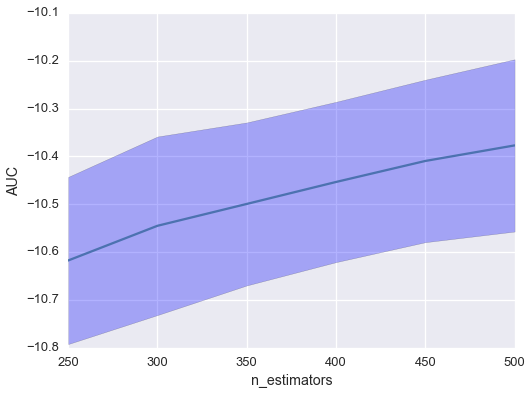

In [47]:
plot_quality(grid_searcher, 'n_estimators')

In [54]:
%%time

kwargs = {'objective':'reg:linear', 'missing': -9999, 'seed': 56, 'n_estimators': 500}

params = {'learning_rate': [0.1, 0.5, 1, 2, 5]}


grid_searcher = GridSearchCV(XGBR(**kwargs), params, 
                             cv=LabelKFold(dfXtrain['codepostal'], n_folds=5), scoring=mape_scorer, n_jobs=1)
grid_searcher.fit(x_train, y_train)

print(grid_searcher.best_score_)
print(grid_searcher.best_estimator_)

-10.3770523707
XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=-9999, n_estimators=500, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=56, silent=True, subsample=1)
CPU times: user 1h 39min 59s, sys: 27.3 s, total: 1h 40min 26s
Wall time: 26min 4s


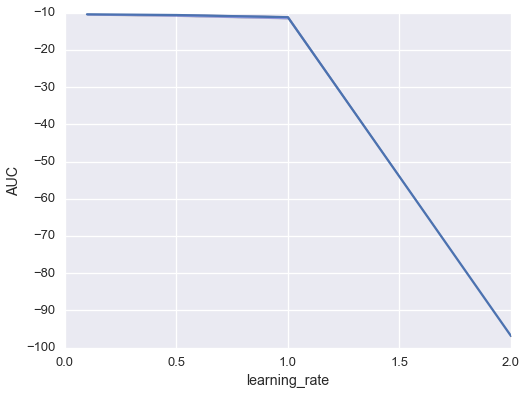

In [55]:
plot_quality(grid_searcher, 'learning_rate')

# Save

In [49]:
kwargs = {'objective':'reg:linear', 'missing': -9999, 'seed': 56, 'n_estimators': 500}


clf = XGBR(**kwargs)
clf.fit(x_train, y_train)
y_predict = clf.predict(x_test)

y_predict

array([ 311.22070312,  199.0196228 ,  263.26882935, ...,  422.54302979,
        363.71792603,  303.35507202], dtype=float32)

In [53]:
save_to_file(y_predict, 'xbg_500.csv')